In [369]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd
from videpy import Vide

import networkx as nx
# from causalgraphicalmodels import CausalGraphicalModel

import stan
import nest_asyncio

plt.style.use('default')

plt.rcParams['axes.facecolor'] = 'lightgray'

# To DAG's
import daft
from causalgraphicalmodels import CausalGraphicalModel

In [2]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

### R Code 7.1 - Pag 194

In [3]:
sppnames = ('afarensis', 'africanus', 'habilis',  'boisei', 'rudolfensis', 'ergaster', 'sapiens')
brainvolcc = (438, 452, 612, 521,  752, 871, 1350)
masskg = (37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5)

d = pd.DataFrame({'species':sppnames, 'brain': brainvolcc, 'mass':masskg})
d

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


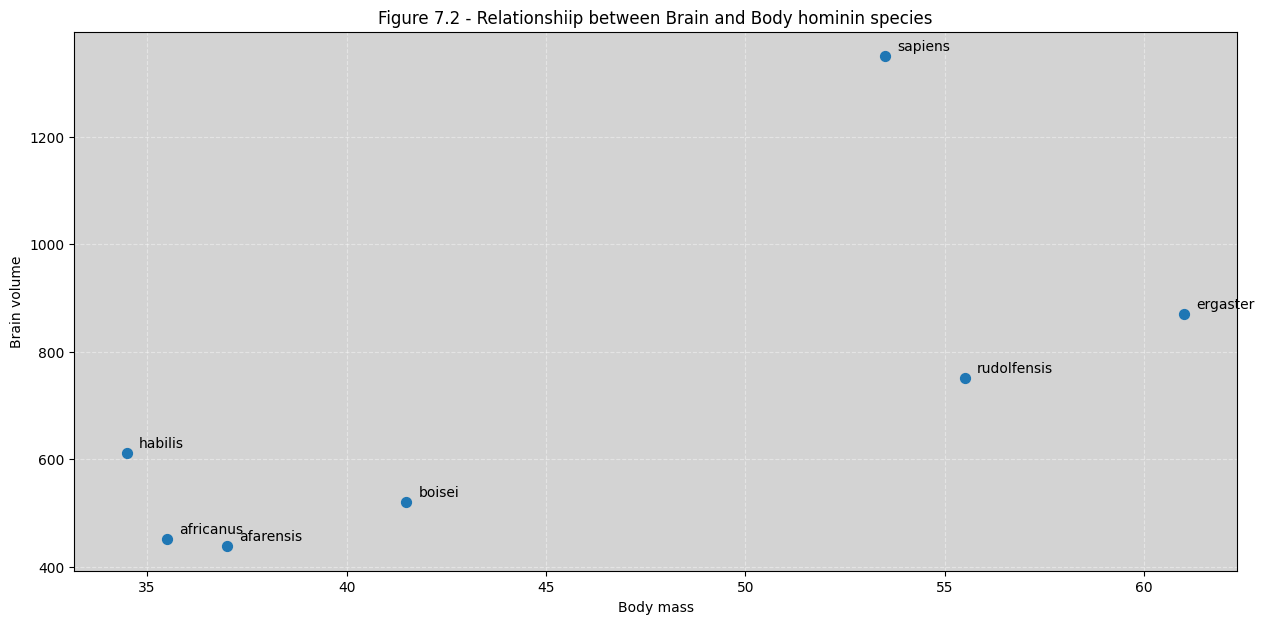

In [4]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(d.mass, d.brain, marker='o', s=50)

for i, text in enumerate(sppnames):
    ax.annotate(text, (d.mass[i]+0.3, d.brain[i]+10))
    
ax.set_title('Figure 7.2 - Relationshiip between Brain and Body hominin species')
ax.set_xlabel('Body mass')
ax.set_ylabel('Brain volume')

ax.grid(ls='--', color='white', alpha=0.4)
plt.show()

### R Code 7.2 - pag 196

In [115]:
np.std(d.mass, ddof=1)

10.90489186863706

In [110]:
d.mass.std()

10.90489186863706

In [119]:
d['mass_std'] = (d.mass - d.mass.mean())/d.mass.std()
d['brain_std'] = d.brain / np.max(d.brain)
d

,species,brain,mass,mass_std,brain_std
0,afarensis,438,37.0,-0.779467,0.324444
1,africanus,452,35.5,-0.917020,0.334815
2,habilis,612,34.5,-1.008722,0.453333
3,boisei,521,41.5,-0.366808,0.385926
4,rudolfensis,752,55.5,0.917020,0.557037
5,ergaster,871,61.0,1.421380,0.645185
6,sapiens,1350,53.5,0.733616,1.000000


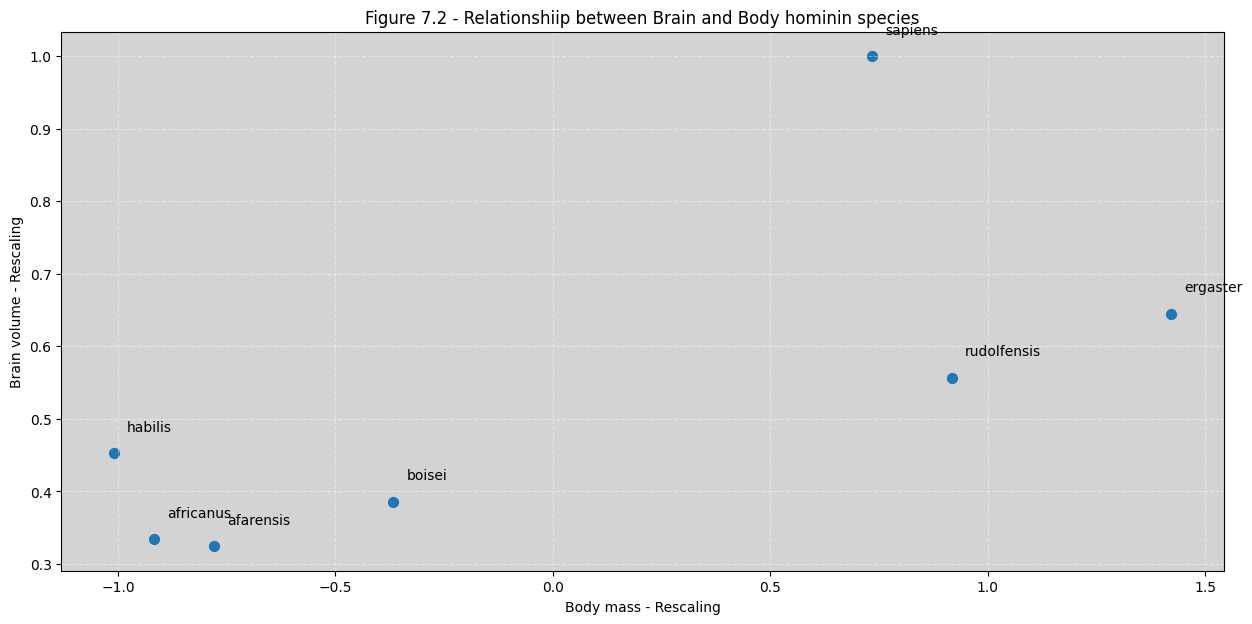

In [120]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(d.mass_std, d.brain_std, marker='o', s=50)

for i, text in enumerate(sppnames):
    ax.annotate(text, (d.mass_std[i]+0.03, d.brain_std[i]+0.03))
    
ax.set_title('Figure 7.2 - Relationshiip between Brain and Body hominin species')
ax.set_xlabel('Body mass - Rescaling')
ax.set_ylabel('Brain volume - Rescaling')

ax.grid(ls='--', color='white', alpha=0.4)
plt.show()

### R Code 7.3 - pag 196

Modelo linear:

$\begin{align}
b_i \sim Normal(\mu_i, \sigma) \\ 
\mu_i = \alpha + \beta m_i \\
\alpha \sim Normal(0.5, 1) \\
\beta \sim Normal(0, 10) \\
\sigma \sim LogNormal(0, 1) \\
\end{align}$





In [132]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta;
        real<lower=0> sigma;
        // real log_sigma;  // Like the book
    }
    
    model {
        vector[N] mu;
        
        mu = alpha + beta * body;
        
        // Likelihood
        brain ~ normal(mu, sigma);
        // brain ~ normal(mu, exp(sigma));  // Like the book
        
        // Prioris
        alpha ~ normal(0.5, 1);
        beta ~ normal(0, 10);
        sigma ~ lognormal(0, 1);
        // log_sigma ~ normal(0, 1);  // Like the book    
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_1 = stan.build(model, data=data)
samples_1 = posteriori_1.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!


In [122]:
Vide.summary(samples_1)

,mean,std,7.0%,93.0%
alpha,0.53,0.11,0.33,0.72
beta,0.17,0.11,-0.03,0.38
sigma,0.27,0.12,0.11,0.45


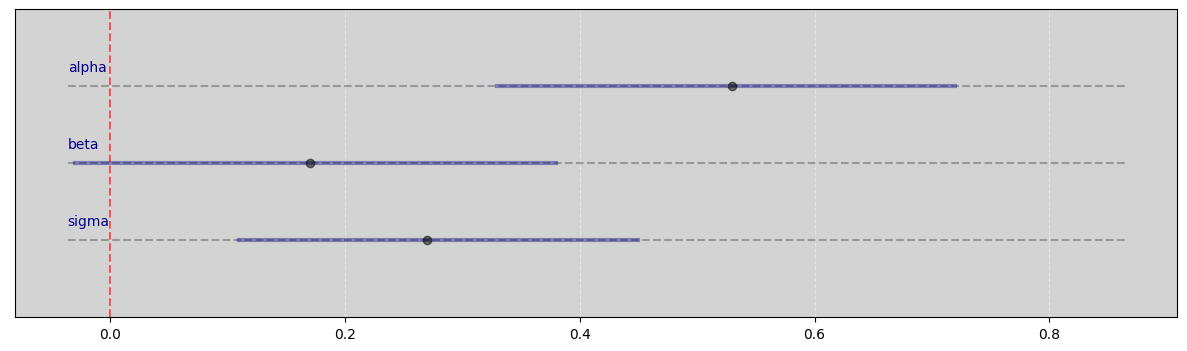

In [123]:
Vide.plot_forest(samples_1)

### R Code 7.4 - pag 196

Just example code in R

`m7.1_OLS <- lm(brain_std ~ brain_std, data=d)`

### R Code 7.5 - pag 197

In [10]:
def var2(x):
    return np.sum(np.power(x - np.mean(x), 2))/len(x)

In [11]:
mean_std = [np.mean((samples_1['alpha'].flatten() + samples_1['beta'].flatten() * mass)) for mass in d.mass_std.values]
r = mean_std - d.brain_std

resid_var = var2(r)
outcome_var = var2(d.brain_std)

1 - resid_var/outcome_var

0.49012773934989007

### R Code 7.6 - Pag 197

In [12]:
def R2_is_bad():
    pass

### R Code 7.7 - pag 198

In [13]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[2];
        real<lower=0> sigma;
    }
    
    model {
        vector[N] mu;
        
        mu = alpha + beta[1] * body + beta[2] * body^2;
        
        // Likelihood
        brain ~ normal(mu, sigma);
        
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:2){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 1);    
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_2 = stan.build(model, data=data)
samples_2 = posteriori_2.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_ze48o2rc/model_pkku4vnp.stan', line 20, column 8 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition 

In [14]:
Vide.summary(samples_2)

,mean,std,7.0%,93.0%
alpha,0.61,0.25,0.18,1.06
beta[0],0.18,0.16,-0.08,0.47
beta[1],-0.08,0.23,-0.48,0.32
sigma,0.31,0.16,0.12,0.56


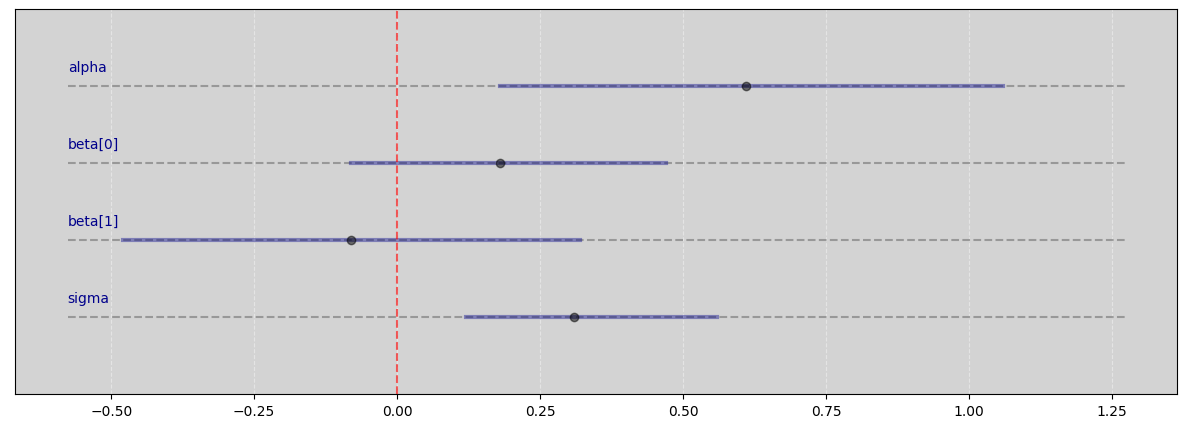

In [15]:
Vide.plot_forest(samples_2)

### R Code 7.8 - Pag 198

In [16]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[3];
        real<lower=0> sigma;
    }
    
    model {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3;
                     
        // Likelihood
        brain ~ normal(mu, sigma);
        
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:3){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 1);    
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_3 = stan.build(model, data=data)
samples_3 = posteriori_3.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  

In [17]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[4];
        real<lower=0> sigma;
    }
    
    model {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3 +
                     beta[4] * body^4;
                     
        // Likelihood
        brain ~ normal(mu, sigma);
        
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:4){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 1);    
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_4 = stan.build(model, data=data)
samples_4 = posteriori_4.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!


In [18]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[5];
        real<lower=0> sigma;
    }
    
    model {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3 +
                     beta[4] * body^4 +
                     beta[5] * body^5;
                     
        // Likelihood
        brain ~ normal(mu, sigma);
        
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:5){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 1);    
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_5 = stan.build(model, data=data)
samples_5 = posteriori_5.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:   5% (400/8000)
Sampling:   9% (700/8000)
Sampling:  15% (1200/8000)
Sampling:  22% (1800/8000)
Sampling:  42% (3400/8000)
Sampling:  64% (5100/8000)
Sampling:  82% (6600/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!


### R Code 7.9 - Pag 199

In [19]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[6];
    }
    
    model {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3 +
                     beta[4] * body^4 +
                     beta[5] * body^5 +
                     beta[6] * body^6;
                     
        // Likelihood
        brain ~ normal(mu, 0.001);
        
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:6){
            beta[j] ~ normal(0, 10);
        }    
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_6 = stan.build(model, data=data)
samples_6 = posteriori_6.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_07foxu_h/model_dq2btk6b.stan', line 24, column 27: Argument 0.001 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   6% (500/8000)
Sampling:  11% (900/8000)
Sampling:  15% (1200/8000)
Sampling:  20% (1600/8000)
Sampling:  22% (1800/8000)
Sampling:  25% (2000/8000)
Sampling:  28% (2200/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  35% (2800/8000)
Sampling:  38% (3000/8000)
Sampling:  55% (4400/8000)
Sampling:  69% (5500/8000)
Sampling:  84% (6700/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog

### R Code 7.10 - Pag 199

In [20]:
mass_seq = np.linspace(start=d.mass_std.min(), stop=d.mass_std.max(), num=100)

In [21]:
pp_1 = [samples_1['alpha'].flatten() + samples_1['beta'].flatten() * mass_i for mass_i in mass_seq]

In [22]:
pp_2 = [samples_2['alpha'].flatten() + 
        samples_2['beta'][0].flatten() * mass_i + 
        samples_2['beta'][1].flatten() * np.power(mass_i, 2) for mass_i in mass_seq]

In [23]:
pp_3 = [samples_3['alpha'].flatten() + 
        samples_3['beta'][0].flatten() * mass_i + 
        samples_3['beta'][1].flatten() * np.power(mass_i, 2) + 
        samples_3['beta'][2].flatten() * np.power(mass_i, 3)
        for mass_i in mass_seq]

In [24]:
pp_4 = [samples_4['alpha'].flatten() + 
        samples_4['beta'][0].flatten() * mass_i + 
        samples_4['beta'][1].flatten() * np.power(mass_i, 2) + 
        samples_4['beta'][2].flatten() * np.power(mass_i, 3) +
        samples_4['beta'][3].flatten() * np.power(mass_i, 4) 
        for mass_i in mass_seq]

In [25]:
pp_5 = [samples_5['alpha'].flatten() + 
        samples_5['beta'][0].flatten() * mass_i + 
        samples_5['beta'][1].flatten() * np.power(mass_i, 2) + 
        samples_5['beta'][2].flatten() * np.power(mass_i, 3) +
        samples_5['beta'][3].flatten() * np.power(mass_i, 4) + 
        samples_5['beta'][4].flatten() * np.power(mass_i, 5) 
        for mass_i in mass_seq]

In [26]:
pp_6 = [samples_6['alpha'].flatten() + 
        samples_6['beta'][0].flatten() * mass_i + 
        samples_6['beta'][1].flatten() * np.power(mass_i, 2) + 
        samples_6['beta'][2].flatten() * np.power(mass_i, 3) +
        samples_6['beta'][3].flatten() * np.power(mass_i, 4) + 
        samples_6['beta'][4].flatten() * np.power(mass_i, 5) + 
        samples_6['beta'][5].flatten() * np.power(mass_i, 6) 
        for mass_i in mass_seq]

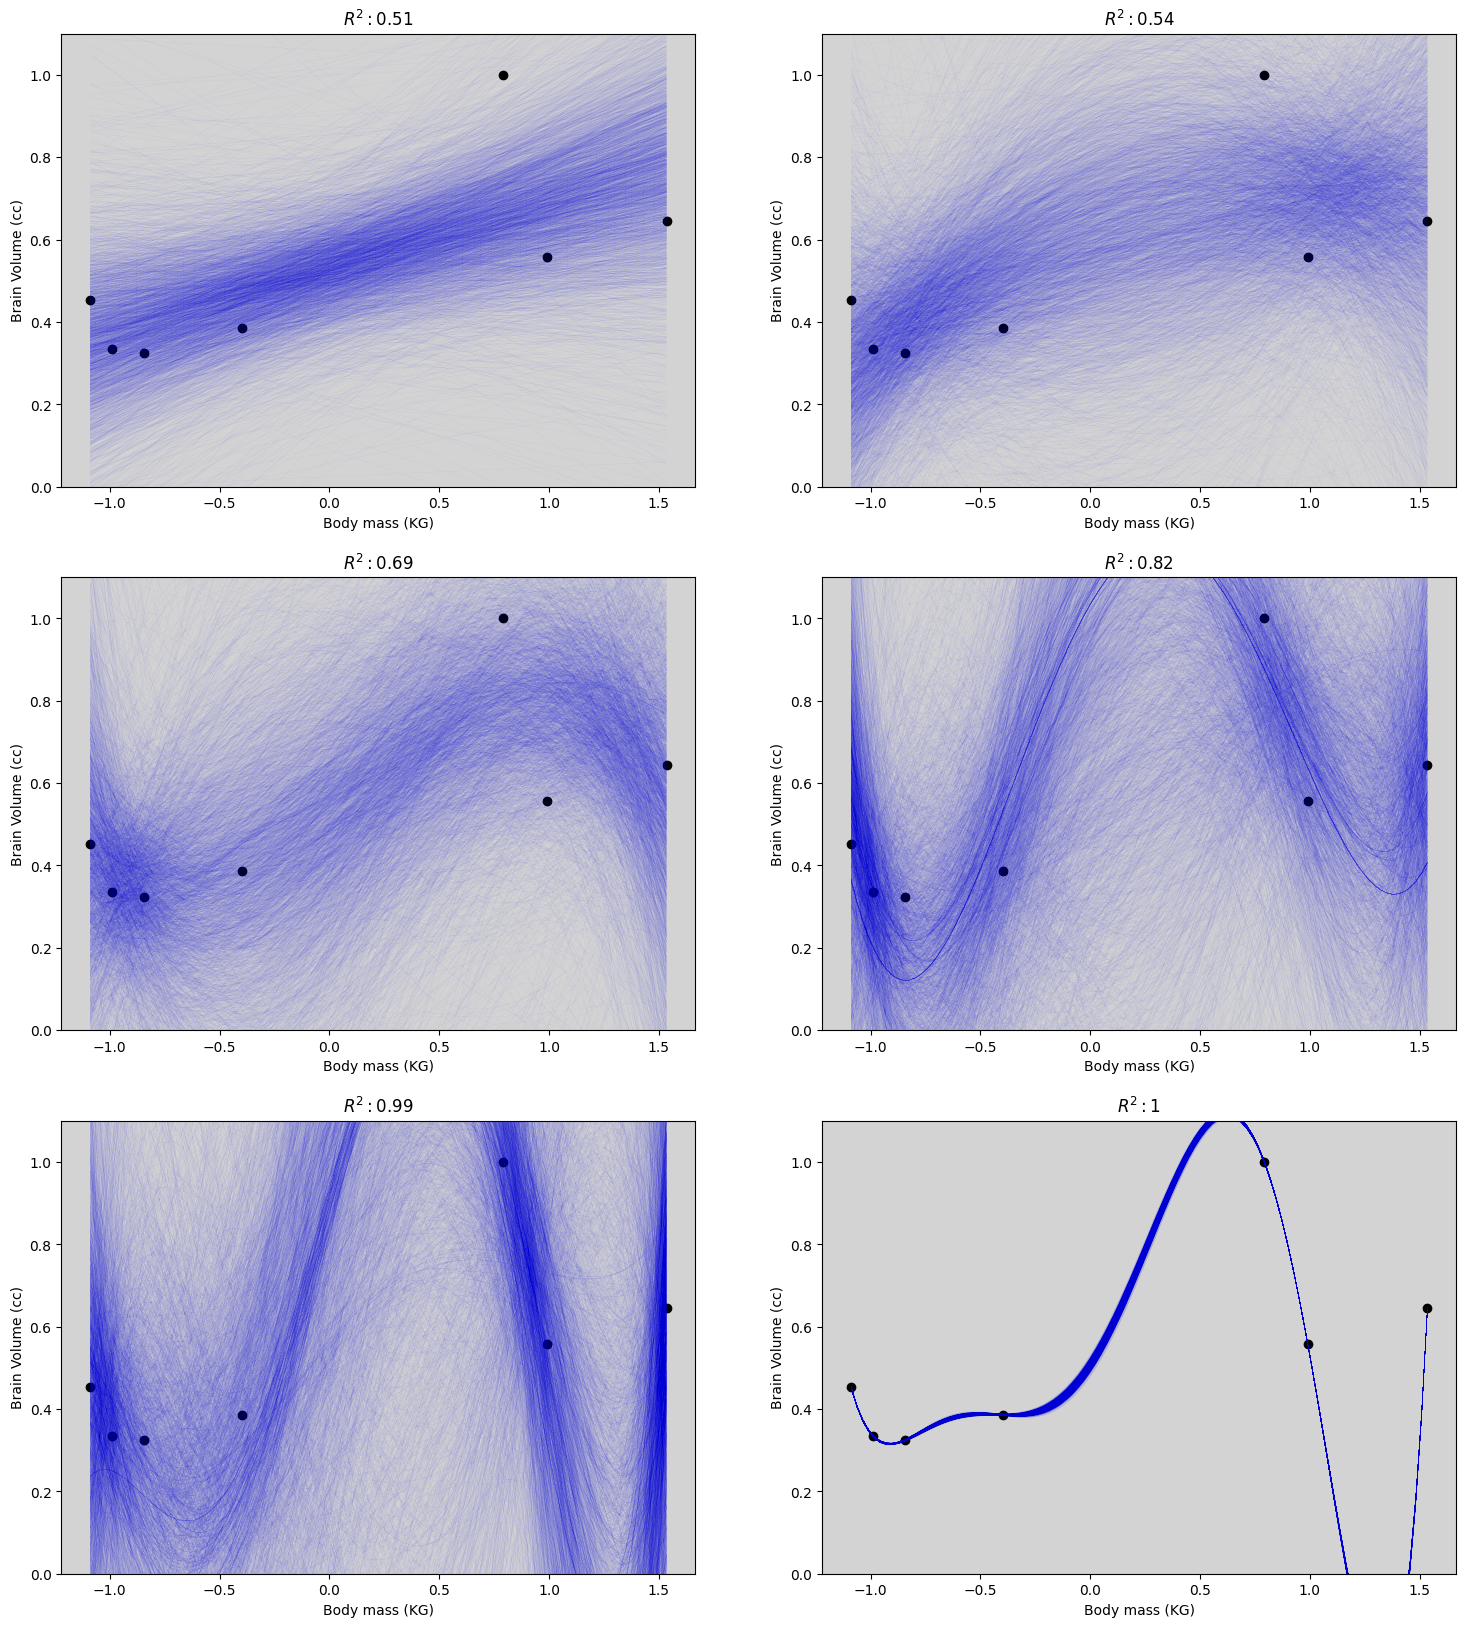

In [27]:
fig = plt.figure(figsize=(18, 20))

gs = GridSpec(nrows=3, ncols=2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(d.mass_std.values, d.brain_std.values, c='black')
ax1.plot(mass_seq, pp_1, c='blue', lw=0.01)
ax1.set_ylim(0, 1.1)
ax1.set_title('$R^2: 0.51$')
ax1.set_xlabel('Body mass (KG)')
ax1.set_ylabel('Brain Volume (cc)')

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(d.mass_std.values, d.brain_std.values, c='black')
ax2.plot(mass_seq, pp_2, c='blue', lw=0.01)
ax2.set_ylim(0, 1.1)
ax2.set_title('$R^2: 0.54$')
ax2.set_xlabel('Body mass (KG)')
ax2.set_ylabel('Brain Volume (cc)')

ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(d.mass_std.values, d.brain_std.values, c='black')
ax3.plot(mass_seq, pp_3, c='blue', lw=0.01)
ax3.set_ylim(0, 1.1)
ax3.set_title('$R^2: 0.69$')
ax3.set_xlabel('Body mass (KG)')
ax3.set_ylabel('Brain Volume (cc)')

ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(d.mass_std.values, d.brain_std.values, c='black')
ax4.plot(mass_seq, pp_4, c='blue', lw=0.01)
ax4.set_ylim(0, 1.1)
ax4.set_title('$R^2: 0.82$')
ax4.set_xlabel('Body mass (KG)')
ax4.set_ylabel('Brain Volume (cc)')

ax5 = fig.add_subplot(gs[2, 0])
ax5.scatter(d.mass_std.values, d.brain_std.values, c='black')
ax5.plot(mass_seq, pp_5, c='blue', lw=0.01)
ax5.set_ylim(0, 1.1)
ax5.set_title('$R^2: 0.99$')
ax5.set_xlabel('Body mass (KG)')
ax5.set_ylabel('Brain Volume (cc)')

ax6 = fig.add_subplot(gs[2, 1])
ax6.scatter(d.mass_std.values, d.brain_std.values, c='black')
ax6.plot(mass_seq, pp_6, c='blue', lw=0.01)
ax6.set_ylim(0, 1.1)
ax6.set_title('$R^2: 1$')
ax6.set_xlabel('Body mass (KG)')
ax6.set_ylabel('Brain Volume (cc)')

plt.show()

### R Code 7.11 - Pag 201

In [28]:
d.brain_std

0    0.324444
1    0.334815
2    0.453333
3    0.385926
4    0.557037
5    0.645185
6    1.000000
Name: brain_std, dtype: float64

Deletando a linha $i=3$ do dataframe:

In [29]:
d_deleted_line_3 = d.brain_std.drop(3)
d_deleted_line_3

0    0.324444
1    0.334815
2    0.453333
4    0.557037
5    0.645185
6    1.000000
Name: brain_std, dtype: float64

### R Code 7.12 - Pag 206

**Entropia da informação**:  *A incerteza contida na distribuição de probabilidade* é a média do $log$ da probabilidade do evento.

In [30]:
def H(p):
    """Information Entropy
    H(p):= -sum(p_i * log(pi))
    """
    if not np.sum(p) == 1:
        print('ProbabilityError: This is not probability, its sum not equal to 1.')
    else:
        return - np.sum([p_i * np.log(p_i) if p_i > 0 else 0 for p_i in p])

In [31]:
p = (0.3, 0.7)  # (p_rain, p_sum)

H(p)

0.6108643020548935

A incerteza do clima de *Abu Dhabi* é menor, pois é pouco provável que chova.

In [32]:
p_AbuDhabi = (0.01, 0.99)  # (p_rain, p_sum)

H(p_AbuDhabi)

0.056001534354847345

In [33]:
p_3dim = (0.7, 0.15, 0.15)  # (p_1, p_2, p_3)

H(p_3dim)

0.818808456222877

### R Code 7.13 - pag 210

References:  

- https://stackoverflow.com/questions/49147905/how-to-extract-posterior-samples-of-log-likelihood-from-pystan

- https://mc-stan.org/docs/2_20/functions-reference/normal-distribution.html

**Obs**:

Here I learned to use the two blocks in stan: *transformed parameters* and *generated quantities*.

To calculate the **Deviance** it is necessary to make these changes. 

That's why I did all 6 estimates again with the calculations needed.

In [335]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta;
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        
        mu = alpha + beta * body;
    }
    
    model {
        // Prioris
        alpha ~ normal(0.5, 1);
        beta ~ normal(0, 10);
        sigma ~ exponential(1);    
        
        // Likelihood
        brain ~ normal(mu, sigma);
    }
    
    generated quantities {
        vector[N] log_ll_y;
        
        for(i in 1:N){
            log_ll_y[i] = normal_lpdf(brain[i] | mu,  sigma);
        }
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_1 = stan.build(model, data=data)
samples_1_NEW = posteriori_1.sample(num_chains=4, num_samples=1000)

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 

In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:110,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:7,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/l2cspjqf/model_l2cspjqf.cpp:2:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/generalized_inverse.hpp: In function ‘Eigen::Matrix<typename stan::value_type<T>::type, EigMat::ColsAtCo

Building: 7.3s
Building: 7.4s
Building: 7.5s
Building: 7.6s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:321,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:7,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/l2cspjqf/model_l2cspjqf.cpp:2:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/tail.hpp: In function ‘std::vector<T1> stan::math::tail(const std::vector<T1>&, size_t)’:
/home/rodolpho

Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:32,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/l2cspjqf/model_l2cspjqf.cpp:2:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/cholesky_decompose.hpp: In lambda function:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/cholesky_decompose.hpp:83:11: warning: typedef ‘using Block_ = class Eigen::Block<Eigen::Mat

Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:74,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/l2cspjqf/model_l2cspjqf.cpp:2:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/generalized_inverse.hpp: In function ‘auto stan::math::generalized_inverse(const VarMat&)’:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/generalized_inverse.hpp:64:9: warning: typed

Building: 9.9s
Building: 10.0s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:121,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/l2cspjqf/model_l2cspjqf.cpp:2:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/lub_constrain.hpp: In function ‘auto stan::math::lub_constrain(const T&, const L&, const U&)’:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/lub_constrain.hpp:485:9: warning: typede

Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.9s
Building: 11.0s
Building: 11.1s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob/bernoulli_logit_glm_log.hpp:5,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob.hpp:10,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim.hpp:16,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:13,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/l2cspjqf/model_l2cspjqf.cpp:2:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/py

Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob/multi_normal_cholesky_log.hpp:6,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob.hpp:196,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim.hpp:16,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:13,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/l2cspjqf/model_l2cspjqf.cpp:2:
/home/rodolpho/Projects/rethinking/RETHINKING/lib

Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob/ordered_logistic_log.hpp:5,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob.hpp:248,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim.hpp:16,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:13,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/l2cspjqf/model_l2cspjqf.cpp:2:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/pyth

Building: 12.7s
Building: 12.8s
Building: 12.9s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/indexing.hpp:7,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:17,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/l2cspjqf/model_l2cspjqf.cpp:2:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/indexing/assign_varmat.hpp: In function ‘void stan::model::assign(Mat1&&, const Mat2&, const char*, const stan::model::index_multi&, const stan::model::index_multi&)’:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/indexing/assign_varmat.hpp:329:9: warning: typedef ‘using pair_type = struct std::pair<int, std::vector<int, stan::math::arena_allocator<int> > >’ locally defined but not used [-Wunused-local-typedefs]
  329 |   using pair_type = std::pair<int, a

Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s


/home/rodolpho/.cache/httpstan/4.5.0/models/l2cspjqf/model_l2cspjqf.cpp: In instantiation of ‘void model_l2cspjqf_namespace::model_l2cspjqf::transform_inits_impl(const stan::io::var_context&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_std_vector_t<T>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.5.0/models/l2cspjqf/model_l2cspjqf.cpp:467:68:   required from here
/home/rodolpho/.cache/httpstan/4.5.0/models/l2cspjqf/model_l2cspjqf.cpp:301:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  301 |       int pos__;
      |           ^~~~~


Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.6s
Building: 14.7s
Building: 14.8s
Building: 14.9s
Building: 15.0s
Building: 15.1s
Building: 15.2s
Building: 15.3s
Building: 15.4s
Building: 15.5s
Building: 15.6s
Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.0s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.5s
Building: 16.6s
Building: 16.7s
Building: 16.8s
Building: 16.9s
Building: 17.0s
Building: 17.1s
Building: 17.2s
Building: 17.3s
Building: 17.4s
Building: 17.5s
Building: 17.6s
Building: 17.7s
Building: 17.8s
Building: 17.9s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/err/check_not_nan.hpp:5,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/err/check_2F1_converges.hpp:5,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/err.hpp:4,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core.hpp:53,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:8,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp

Building: 18.0s
Building: 18.1s
Building: 18.3s
Building: 18.4s
Building: 18.5s
Building: 18.6s
Building: 18.7s
Building: 18.8s
Building: 18.9s
Building: 19.0s
Building: 19.1s
Building: 19.2s
Building: 19.3s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 19.9s
Building: 20.0s
Building: 20.1s
Building: 20.2s
Building: 20.3s
Building: 20.4s
Building: 20.5s
Building: 20.6s
Building: 20.7s
Building: 20.8s
Building: 20.9s
Building: 21.0s
Building: 21.1s
Building: 21.2s
Building: 21.3s
Building: 21.4s
Building: 21.5s
Building: 21.6s
Building: 21.7s
Building: 21.8s
Building: 21.9s
Building: 22.1s
Building: 22.2s
Building: 22.3s
Building: 22.4s
Building: 22.5s
Building: 22.6s
Building: 22.7s
Building: 22.8s
Building: 22.9s
Building: 23.0s
Building: 23.1s
Building: 23.2s
Building: 23.3s
Building: 23.4s
Building: 23.5s
Building: 23.6s
Building: 23.7s
Building: 23.8s
Building: 23.9s
Building: 24.0s
Building: 24.1s
Building: 24.2s
Building: 24.3s
Building

Building: 31.8s, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!


In [35]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[2];
        real<lower=0> sigma;
    }
    
    transformed parameters{
        vector[N] mu;
        mu = alpha + beta[1] * body + 
                     beta[2] * body^2;
    }
    
    model {
        // Likelihood
        brain ~ normal(mu, sigma);
        
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:2){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 1);    
    }
    
    generated quantities {
        vector[N] log_ll_y;
        
        for (i in 1:N){
            log_ll_y[i] = normal_lpdf(brain[i] | mu, sigma);
        }
    
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_2 = stan.build(model, data=data)
samples_2 = posteriori_2.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_17gqtc8l/model_v2v2mm73.stan', line 22, column 8 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition wo

In [36]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[3];
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3;
    }
    
    model {                     
        // Likelihood
        brain ~ normal(mu, sigma);
        
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:3){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 1);    
    }
    
    generated quantities {
        vector[N] log_ll_y;
        
        for (i in 1:N){
            log_ll_y[i] = normal_lpdf(brain[i] | mu, sigma);
        }
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_3 = stan.build(model, data=data)
samples_3 = posteriori_3.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

In [37]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[4];
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3 +
                     beta[4] * body^4;
    }
    
    model {
                             
        // Likelihood
        brain ~ normal(mu, sigma);
        
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:4){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 1);    
    }
    
    generated quantities {
        vector[N] log_ll_y;
    
        for (i in 1:N){
            log_ll_y[i] = normal_lpdf(brain[i] | mu, sigma);
        }
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_4 = stan.build(model, data=data)
samples_4 = posteriori_4.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  11% (900/8000)
Sampling:  36% (2900/8000)
Sampling:  61% (4900/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!


In [38]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[5];
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3 +
                     beta[4] * body^4 +
                     beta[5] * body^5;
    }
    
    model {          
        // Likelihood
        brain ~ normal(mu, sigma);
        
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:5){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 1);    
    }
    
    generated quantities {
        vector[N] log_ll_y;
        
        for (i in 1:N){
            log_ll_y[i] = normal_lpdf(brain[i] | mu, sigma);
        }
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_5 = stan.build(model, data=data)
samples_5 = posteriori_5.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   6% (500/8000)
Sampling:  11% (900/8000)
Sampling:  18% (1400/8000)
Sampling:  40% (3200/8000)
Sampling:  61% (4900/8000)
Sampling:  81% (6500/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!


In [39]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[6];
    }
    
    transformed parameters {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3 +
                     beta[4] * body^4 +
                     beta[5] * body^5 +
                     beta[6] * body^6;
    }
    
    model {          
        // Likelihood
        brain ~ normal(mu, 0.001);
        
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:6){
            beta[j] ~ normal(0, 10);
        }    
    }
    
    generated quantities {
        vector[N] log_ll_y;
        
        for (i in 1:N){
            log_ll_y[i] = normal_lpdf(brain[i] | mu, 0.001);
        }
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_6 = stan.build(model, data=data)
samples_6 = posteriori_6.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_usm7o_9q/model_3ifteqea.stan', line 26, column 27: Argument 0.001 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   6% (500/8000)
Sampling:  11% (900/8000)
Sampling:  15% (1200/8000)
Sampling:  20% (1600/8000)
Sampling:  22% (1800/8000)
Sampling:  25% (2000/8000)
Sampling:  28% (2200/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  50% (4000/8000)
Sampling:  69% (5500/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjus

In [423]:
def lppd(samples, outcome, std_residuals=True):
    """ Calculate the LOG-POINTWISE-PREDICTIVE-DENSITY
    
    samples : stan
        Sampler results of fit posteriori. 
        Need 'mu' already computed.
    
    outcome : list
        List with outcomes the original data.
        
    std_residuals : booleans
        Compute lppd using std of the residuals 
    """
    mu = samples['mu']
    N = len(outcome)
    k = np.shape(mu)[1]  # Qty samples from predictive posteriori

    outcome = outcome.reshape(-1, 1)

    if std_residuals:
        sigma = np.sqrt(np.sum(np.power((samples['mu'] - outcome), 2), 0) / N)    
    else:
        sigma = samples['sigma'].flatten()
        
    lppd = np.empty(N, dtype=float)
    for i in range(N):
        log_posteriori_predictive = stats.norm.logpdf(outcome[i], mu[i], sigma)
        lppd[i] =  np.log(np.sum(np.exp(log_posteriori_predictive))) - np.log(k)
    
    return lppd    

In [424]:
lppd(samples_1_NEW, d.brain_std.values)

array([ 0.54447089,  0.57932511,  0.49270636,  0.55932204,  0.41863591,
        0.37960746, -0.77828081])

-------

In [51]:
from scipy.stats import norm

$$ y \sim Normal(0, 0.3) $$

In [309]:
len(sigma)

4000

In [317]:
lppd = np.empty(7)

for i in range(len(d)):
    lpd = norm.logpdf(d.brain_std[i], mu[i].flatten(), sigma)
    lppd[i] = np.log(np.sum(np.exp(lpd[i]))) - np.log(len(sigma))
lppd

array([-8.09833098, -8.91360981, -7.8598324 , -7.61743961, -8.41463636,
       -8.99383068, -8.85574164])

In [ ]:
muc

In [319]:
np.mean(samples_1['sigma'].flatten())

0.2666908344983434

In [348]:
alpha1 = samples_1['alpha'].flatten()
beta1 = samples_1['beta'].flatten()
sigma1 = samples_1['sigma'].flatten()

mu1 = alpha1 + beta1 * d.mass_std[1]

In [351]:
print(mu1.mean())
print(mu1.std())

0.37287852470000904
0.1513103958037016


In [344]:
print(samples_1_NEW['mu'][1].mean())
print(samples_1_NEW['mu'][1].std())

0.37663577290000344
0.13899387457444123


In [366]:
std_resid = np.sqrt(np.sum((samples_1_NEW['mu'] - d.brain_std.values.reshape(-1, 1))**2, 0)/7)
print(std_resid.mean())
print(std_resid.std())

0.20357168241396262
0.058060122669363674


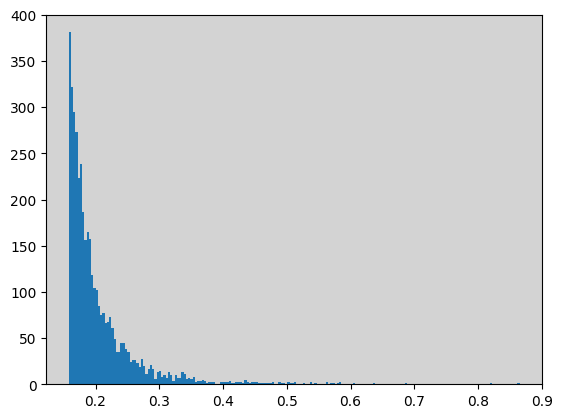

In [368]:
plt.hist(std_resid, bins=200)
plt.show()

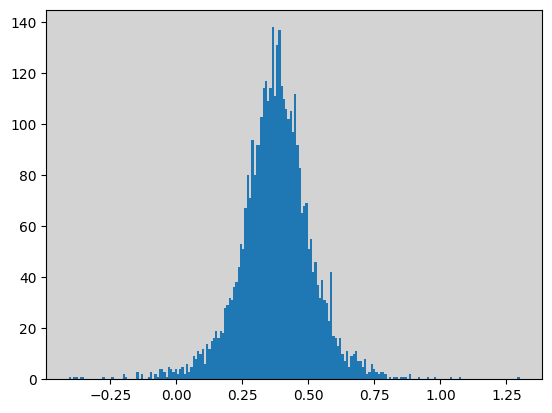

In [340]:
plt.hist(samples_1_NEW['mu'][1], bins=200)
plt.show()

In [288]:
np.mean(samples_1_NEW['sigma'].flatten())

0.2666908344983434

In [290]:
np.mean(samples_1_NEW['mu'], axis=1)

array([0.39630992, 0.37287852, 0.3572576 , 0.46660409, 0.68529706,
       0.77121216, 0.65405521])

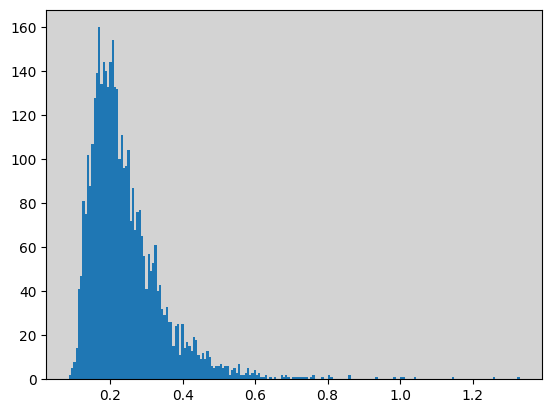

In [336]:
plt.hist(samples_1_NEW['sigma'].flatten(), bins=200)
plt.show()

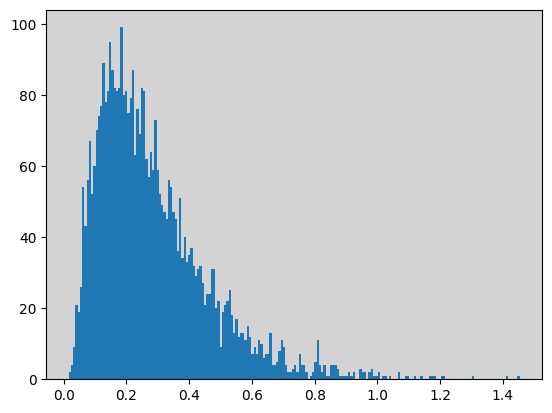

In [326]:
plt.hist(samples_1_NEW['sigma'].flatten(), bins=200)
plt.show()

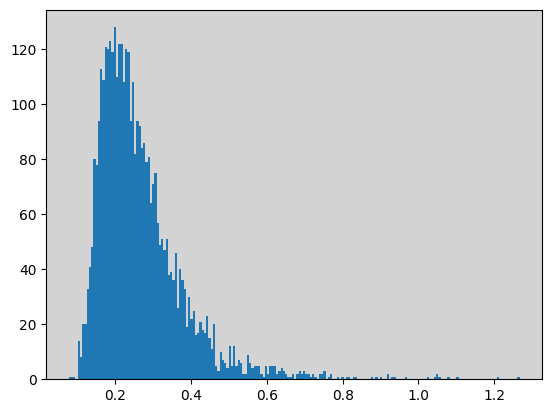

In [327]:
plt.hist(samples_1['sigma'].flatten(), bins=200)
plt.show()

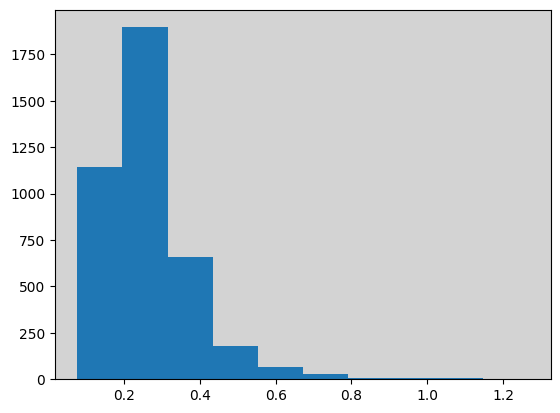

In [287]:
plt.hist(samples_1_NEW['sigma'].flatten())
plt.show()

In [284]:
lppd = np.empty([7, 1], dtype=float)
for i in range(7):
    lppd[i] = np.log(np.sum(np.exp(nlp[i]))) - np.log(np.shape(samples_1_NEW['sigma'])[1])

In [285]:
lppd

array([[ 0.38622666],
       [ 0.41031895],
       [ 0.31981025],
       [ 0.39898571],
       [ 0.26428262],
       [ 0.22120647],
       [-0.59062356]])